In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq, kmeans, whiten

import jax
import jax.numpy as jnp
from jax.config import config as jax_config

jax_config.update("jax_enable_x64", True)

import cryo_md

from cryo_md.data_generator import data_generator
from cryo_md.optimizer import run_optimizer
from cryo_md.analysis import calc_population_models

In [10]:
n_points = np.array([100, 300, 800])
centers = np.array([[-20, 0], [0, 10], [10, 0]])

cov = np.array([[3, 0], [0, 3]])

data = data_generator(centers, cov, n_points)

In [11]:
np.mean(centers, axis=0)

array([-3.33333333,  3.33333333])

In [12]:
np.random.seed(1234)
n_models = 20

# homo_model = np.mean(data, axis=0)
homo_model = np.mean(centers, axis=0)
init_models = np.repeat(homo_model.reshape(1, -1), n_models, axis=0)
# init_models[2] = np.array([-20, -20])

init_models = np.random.randn(n_models, data.shape[1]) * 3 + np.mean(centers, axis=0)

weights = np.ones(init_models.shape[0]) / init_models.shape[0]

# weights = np.random.rand(n_models)
# weights /= np.sum(weights)

# prior_center = np.mean(centers, axis=0)

prior_center = np.array([0.0, 5.0])

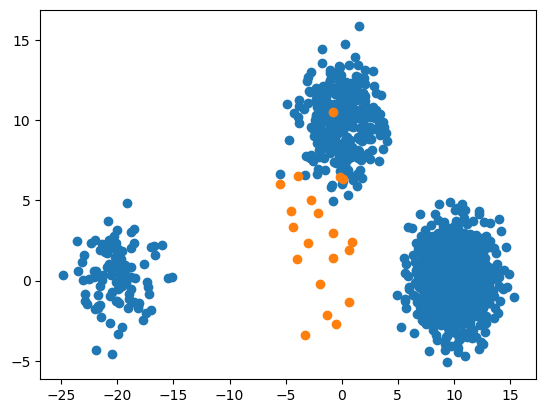

In [13]:
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(init_models[:, 0], init_models[:, 1])

In [14]:
config = {
    "samp_steps": 100,
    "samp_step_size": 0.01,
    "md_force_constant": 1.0,
    "samp_bias_force": 2.0,
    "opt_steps": 1000,
    "opt_step_size": 0.1,
    "batch_size": data.shape[0],
    "sigma": 1.0,
    "gamma": 0.1,
    "delta_sigma": 1,
    "stride": 10,
}

cryo_md.utils.check_config(config)

In [89]:
traj_struct, traj_weights = run_optimizer(
    init_models, weights, data, prior_center, config, seed=1234
)

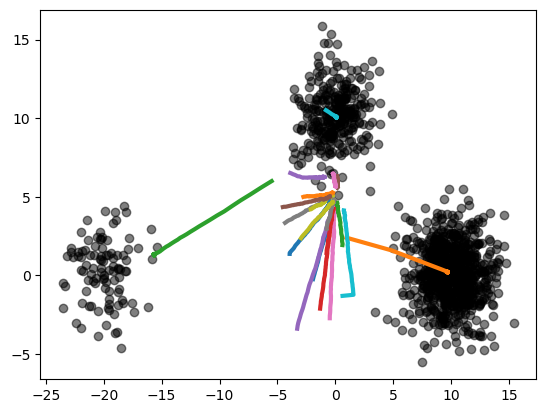

In [90]:
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color="black")

for i in range(traj_struct.shape[1]):
    plt.plot(traj_struct[:, i, 0], traj_struct[:, i, 1], linewidth=3)

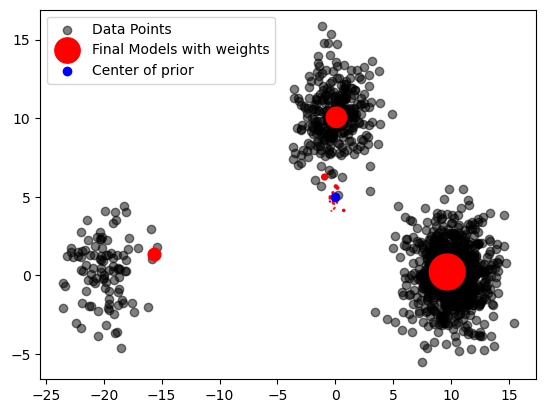

In [94]:
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color="black", label="Data Points")

plt.scatter(
    traj_struct[-1, :, 0],
    traj_struct[-1, :, 1],
    color="red",
    s=traj_weights[-1, :] * 1000,
    label="Final Models with weights",
)

plt.scatter(prior_center[0], prior_center[1], color="blue", label="Center of prior")
plt.legend()

In [66]:
traj_weights[-1, :]

array([0.00185376, 0.3333154 , 0.33333333, 0.00204736, 0.00222737,
       0.00213134, 0.00200587, 0.00168214, 0.00228786, 0.00194174,
       0.00213352, 0.00183681, 0.00238075, 0.00209254, 0.08222422,
       0.00162742, 0.00149876, 0.0018902 , 0.00178238, 0.21970723])

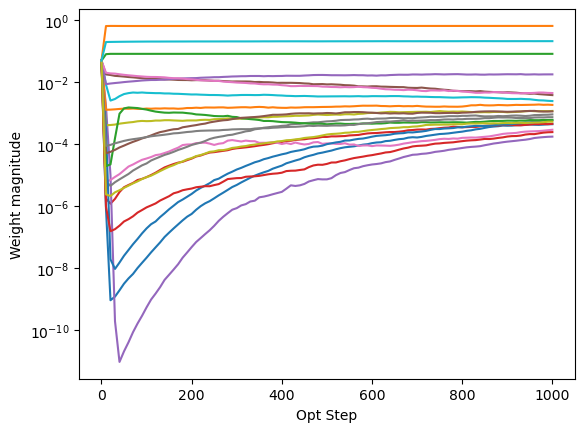

In [95]:
sim_steps = np.arange(0, config["opt_steps"] + 1, config["stride"])

for i in range(traj_weights.shape[1]):
    plt.plot(sim_steps, traj_weights[:, i], label=f"Wts Mod {i}")

plt.xlabel("Opt Step")
plt.ylabel("Weight magnitude")
# plt.legend()

plt.yscale("log")

In [92]:
calc_population_models(traj_struct[-1], traj_weights[-1], data, n_clusters=3)

Obtained: 0.664, Data: 0.667
Obtained: 0.252, Data: 0.250
Obtained: 0.083, Data: 0.083


In [11]:
weights

array([0.15304954, 0.49714773, 0.34980274])